# 1

In [47]:
# Libraries
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# Helper Functions and circuits

def hadamard_transform(wire_list):
    for wire in wire_list:
        qml.Hadamard(wires=wire)
    pass

def oracle(combo, wires):
    qml.MultiControlledX(wires=wires, control_values=combo)
    pass

def diffusion(query_register, all_wires):
    hadamard_transform(query_register)
    qml.MultiControlledX(wires=all_wires, control_values=[0]*len(query_register))
    hadamard_transform(query_register)
    pass


def grover_iter(combo, num_steps):
    """Run Grover search for a given secret combination and a number of iterations.

    Args:
        combo (list[int]): The secret combination, represented as a list of bits.
        num_steps (int): The number of Grover iterations to perform.

    Returns:
        array[float]: Probability for observing different outcomes.
    """
    n_bits = len(combo)
    query_register = list(range(n_bits))
    aux = [n_bits]
    all_wires = query_register + aux
    
    dev = qml.device("default.qubit", wires=all_wires)
    @qml.qnode(dev)
    def inner_circuit():
        # PREPARE AUXILIARY AND QUERY REGISTER 
        qml.PauliX(aux)
        hadamard_transform(all_wires)
        

        # APPLY GROVER ITERATION
        for _ in range(num_steps):
            oracle(combo, all_wires)
            diffusion(query_register, all_wires)

        return qml.probs(wires=query_register)

    return inner_circuit()

def run_experiment(grover_variant, max_num_steps, combo):
    prob_list = []
    for num_steps in range(max_num_steps):
        result = grover_variant(combo, num_steps)
        index = np.ravel_multi_index(combo, [2] * len(combo))
        prob_list.append(result[index])
    return prob_list

def estimate_expected_optimal_steps(combo):
    return round( np.pi/4 * np.sqrt(2**len(combo)) )

Expected optimal number of steps: 2


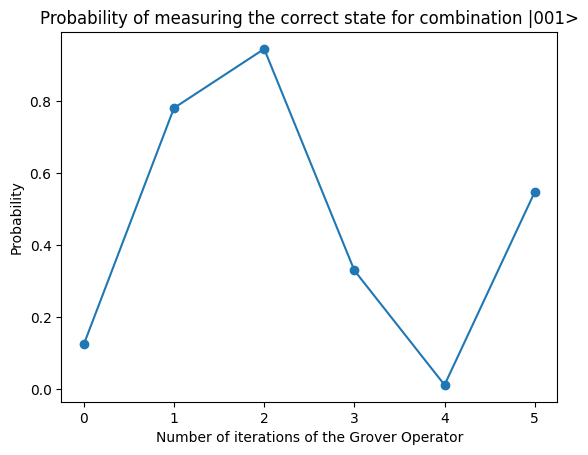

In [49]:
max_num_steps = 6
combo = (0,0,1)
print(f"Expected optimal number of steps: {estimate_expected_optimal_steps(combo)}")

plt.plot(range(max_num_steps), run_experiment(grover_iter, max_num_steps, combo), marker='o')
plt.xlabel("Number of iterations of the Grover Operator")
plt.ylabel("Probability")
plt.title(f"Probability of measuring the correct state for combination |{"".join(str(c) for c in combo)}>")
plt.show()

## PPM

In [50]:
def grover_iter_ppm(combo, num_steps):
    """Run Grover search for a given secret combination and a number of iterations.

    Args:
        combo (list[int]): The secret combination, represented as a list of bits.
        num_steps (int): The number of Grover iterations to perform.

    Returns:
        array[float]: Probability for observing different outcomes.
    """
    n_bits = len(combo)
    query_register = list(range(n_bits))
    aux = [n_bits]
    all_wires = query_register + aux
    
    dev = qml.device("default.qubit", wires=all_wires)
    @qml.qnode(dev)
    def inner_circuit():
        # PREPARE AUXILIARY AND QUERY REGISTER 
        qml.PauliX(aux)
        hadamard_transform(all_wires)

        # In this variant we are asked to set the last query register as a |-> state
        qml.PauliZ(query_register[-1])

        # APPLY GROVER ITERATION
        for _ in range(num_steps):
            oracle(combo, all_wires)
            diffusion(query_register, all_wires)

        return qml.probs(wires=query_register)

    return inner_circuit()

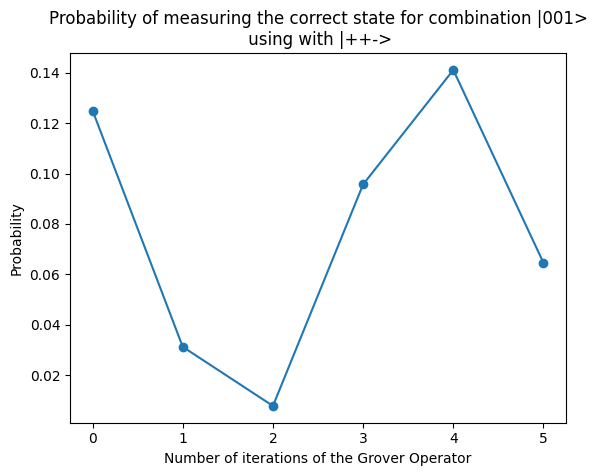

In [54]:
max_num_steps = 6
combo = (0,0,1)

plt.plot(range(max_num_steps), run_experiment(grover_iter_ppm, max_num_steps, combo), marker='o')
plt.xlabel("Number of iterations of the Grover Operator")
plt.ylabel("Probability")
plt.title(f"Probability of measuring the correct state for combination |{"".join(str(c) for c in combo)}>\n using with |++->")
plt.show()

## Mult

In [ ]:
# New Helper Functions and updated functions

def combos_list_to_str(combos_list):
    combos_list_str = []
    for combo in combos_list:
        combos_list_str.append("".join(str(c) for c in combo))
    return combos_list_str


def oracle_mult(combos_list, wires):
    for combo in combos_list:
        qml.MultiControlledX(wires=wires, control_values=combo)
    pass

def grover_iter_mult(combo_list, num_steps):
    """Run Grover search for a given secret combination and a number of iterations.

    Args:
        combo_list (list[int]): A list of secret combinations, represented as a list of bits.
        num_steps (int): The number of Grover iterations to perform.

    Returns:
        array[float]: Probability for observing different outcomes.
    """
    n_bits = len(combo_list[0])
    query_register = list(range(n_bits))
    aux = [n_bits]
    all_wires = query_register + aux
    
    dev = qml.device("default.qubit", wires=all_wires)
    @qml.qnode(dev)
    def inner_circuit():
        # PREPARE AUXILIARY AND QUERY REGISTER 
        qml.PauliX(aux)
        hadamard_transform(all_wires)

        # APPLY GROVER ITERATION
        for _ in range(num_steps):
            oracle_mult(combo_list, all_wires)
            diffusion(query_register, all_wires)

        return qml.probs(wires=query_register)

    return inner_circuit()

def run_experiment(grover_variant, max_num_steps, combos_list):
    all_probs = []
    for num_steps in range(max_num_steps):
        result = grover_variant(combos_list, num_steps)
        indices = [np.ravel_multi_index(combo, [2] * len(combo)) for combo in combos_list]
        all_probs.append(result[indices])
    return np.array(all_probs)

def estimate_expected_optimal_steps_mult(combo_list):
    return round( np.pi/4 * np.sqrt(2**len(combo_list[0])/ len(combo_list)) )

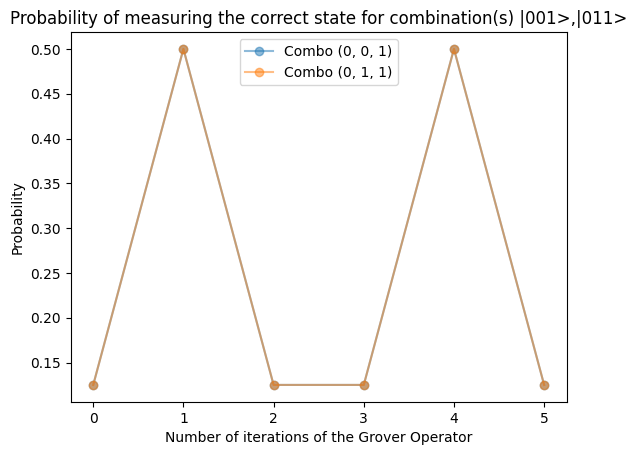

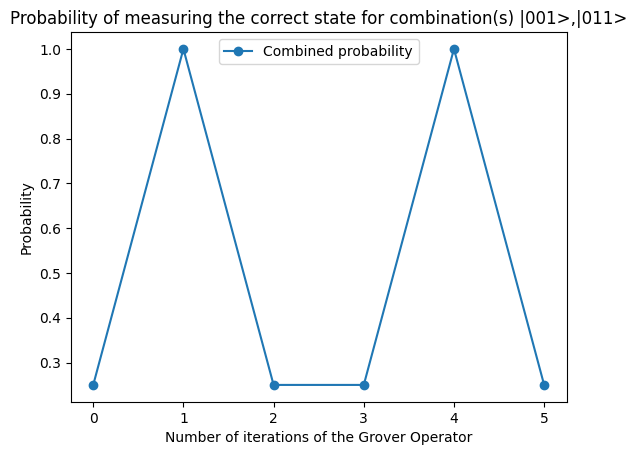

In [44]:
max_num_steps = 6
combos_list = [(0,0,1), (0,1,1)]
all_probs = run_experiment(grover_iter_mult, max_num_steps, combos_list)

# Separated by combination
for i, combo in enumerate(combos_list):
    plt.plot(range(max_num_steps), all_probs[:,i], marker='o', label=f"Combo {combo}", alpha=0.5)
plt.xlabel("Number of iterations of the Grover Operator")
plt.ylabel("Probability")
plt.title(f"Probability of measuring the correct state for combination(s) {",".join( "|" + c + ">" for c in combos_list_to_str(combos_list))}")
plt.legend()
plt.show()


# Combined
plt.plot(range(max_num_steps), all_probs.sum(axis=1), marker='o', label=f"Combined probability")
plt.xlabel("Number of iterations of the Grover Operator")
plt.ylabel("Probability")
plt.title(f"Probability of measuring the correct state for combination(s) {",".join( "|" + c + ">" for c in combos_list_to_str(combos_list))}")
plt.legend()
plt.show()

# 2

In [ ]:
import time
import math
import random
from fractions import Fraction
from dataclasses import dataclass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sympy as sp
import pennylane as qml

## Classical factoring

,bits,td_median,sp_median
0,16,0.000007,0.000010
1,20,0.000025,0.000025
2,24,0.000109,0.000185
3,28,0.000395,0.000371
4,32,0.002340,0.000435
5,36,0.009623,0.000582
6,40,0.030100,0.000364


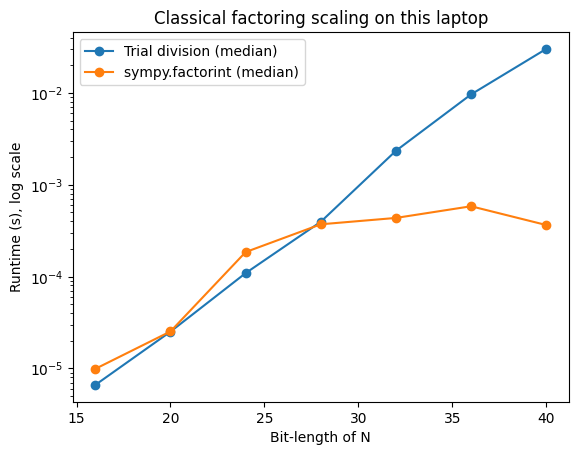

In [56]:
def random_prime(bits, rng=None):
    rng = rng or random.Random()
    a = 1 << (bits - 1)
    b = 1 << bits
    return int(sp.randprime(a, b))

def random_semiprime(bits, rng=None):
    rng = rng or random.Random()
    b1 = bits // 2
    b2 = bits - b1
    p = random_prime(b1, rng=rng)
    q = random_prime(b2, rng=rng)
    return p*q, p, q




def trial_division_factor(n: int):
    """Very basic baseline factoring (slow for large semiprimes)."""
    factors = {}
    if n < 2:
        return factors

    while n % 2 == 0:
        factors[2] = factors.get(2, 0) + 1
        n //= 2

    f = 3
    while f*f <= n:
        while n % f == 0:
            factors[f] = factors.get(f, 0) + 1
            n //= f
        f += 2

    if n > 1:
        factors[n] = factors.get(n, 0) + 1
    return factors





def time_call(fn, *args, repeats=1, **kwargs):
    best = float("inf")
    out = None
    for _ in range(repeats):
        t0 = time.perf_counter()
        out = fn(*args, **kwargs)
        dt = time.perf_counter() - t0
        best = min(best, dt)
    return best, out

def benchmark_classical_factoring(bit_sizes=(16, 20, 24, 28, 32), instances_per_size=5, repeats=1, rng_seed=0):
    rng = random.Random(rng_seed)
    rows = []
    for bits in bit_sizes:
        for _ in range(instances_per_size):
            N, p, q = random_semiprime(bits, rng=rng)

            td_t, td_fac = time_call(trial_division_factor, N, repeats=repeats)
            sp_t, sp_fac = time_call(sp.factorint, N, repeats=repeats)

            rows.append({
                "bits": bits,
                "digits": len(str(N)),
                "N": N,
                "p": p,
                "q": q,
                "trial_div_s": td_t,
                "sympy_factorint_s": sp_t,
            })
    df = pd.DataFrame(rows)
    return df

df_classical = benchmark_classical_factoring(
    bit_sizes=(16, 20, 24, 28, 32, 36, 40),
    instances_per_size=4,
    repeats=1,
    rng_seed=1,
)

dfc = df_classical.groupby("bits", as_index=False).agg(
    td_median=("trial_div_s", "median"),
    sp_median=("sympy_factorint_s", "median"),
)

display(dfc)

plt.figure()
plt.plot(dfc["bits"], dfc["td_median"], marker="o", label="Trial division (median)")
plt.plot(dfc["bits"], dfc["sp_median"], marker="o", label="sympy.factorint (median)")
plt.yscale("log")
plt.xlabel("Bit-length of N")
plt.ylabel("Runtime (s), log scale")
plt.title("Classical factoring scaling on this laptop")
plt.legend()
plt.show()
